In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, multilabel_confusion_matrix, roc_curve, auc

# Paths
train_dir = "Training"
test_dir = "Testing"
model_name = "InceptionV3"
img_size = 299
batch_size = 32

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 4800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [3]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True  # Fine-tuning enabled

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model_inception = Model(inputs=base_model.input, outputs=output)

model_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_inception.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 149, 149, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 149, 149, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 147, 147, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 147, 147, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 73, 73, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 71, 71, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 22,293,924 (85.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [4]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history_inception = model_inception.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, lr_reduce]
)

# Save trained model
model_inception.save(f"{model_name}.h5")

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1234s 8s/step - accuracy: 0.7954 - loss: 0.5342 - val_accuracy: 0.9433 - val_loss: 0.1785 - learning_rate: 1.0000e-04
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1196s 8s/step - accuracy: 0.9595 - loss: 0.1184 - val_accuracy: 0.9083 - val_loss: 0.2529 - learning_rate: 1.0000e-04
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1190s 8s/step - accuracy: 0.9669 - loss: 0.1039 - val_accuracy: 0.9608 - val_loss: 0.1289 - learning_rate: 1.0000e-04
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1184s 8s/step - accuracy: 0.9798 - loss: 0.0672 - val_accuracy: 0.9708 - val_loss: 0.0956 - learning_rate: 1.0000e-04
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1187s 8s/step - accuracy: 0.9881 - loss: 0.0409 - val_accuracy: 0.9867 - val_loss: 0.0512 - learning_rate: 1.0000e-04
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1182s 8s/step - accuracy: 0.9870 - loss: 0.0402 - val_accuracy: 0.9083 - val_loss: 0.3863 - learning_rate: 1.0000e-04
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1187s 8s/ste

In [5]:
loss, acc = model_inception.evaluate(test_generator)
y_true = test_generator.classes
y_pred_probs = model_inception.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9830 - loss: 0.0453
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step


In [6]:
cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
mcm = multilabel_confusion_matrix(y_true, y_pred)

tp = mcm[:, 1, 1].sum()
tn = mcm[:, 0, 0].sum()
fp = mcm[:, 0, 1].sum()
fn = mcm[:, 1, 0].sum()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred_probs, multi_class='ovr')

# Print all metrics
print(f"{model_name} Accuracy     : {acc:.4f}")
print(f"Precision              : {cr['macro avg']['precision']:.4f}")
print(f"Recall                 : {cr['macro avg']['recall']:.4f}")
print(f"F1-Score               : {cr['macro avg']['f1-score']:.4f}")
print(f"Specificity            : {specificity:.4f}")
print(f"ROC AUC                : {roc_auc:.4f}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

InceptionV3 Accuracy     : 0.9900
Precision              : 0.9902
Recall                 : 0.9900
F1-Score               : 0.9900
Specificity            : 0.9967
ROC AUC                : 0.9997
TP: 1188, TN: 3588, FP: 12, FN: 12


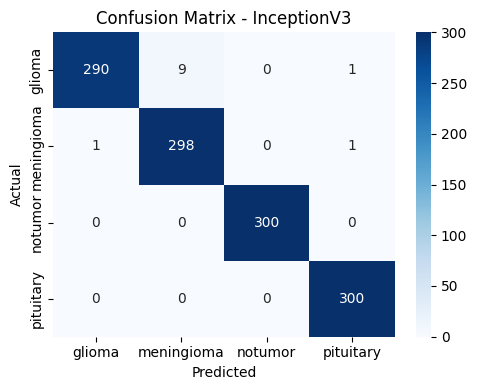

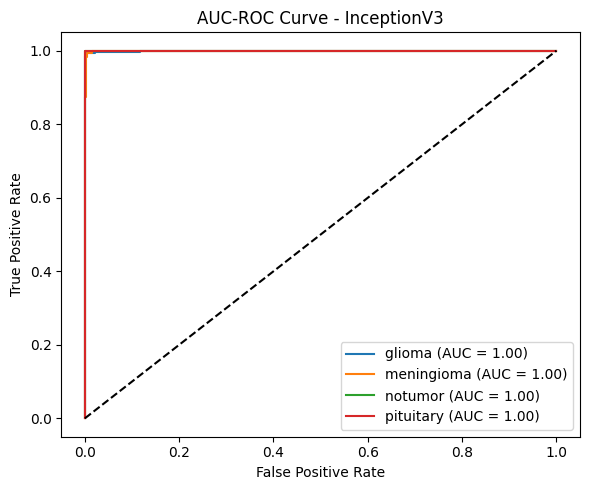

In [7]:
# Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"conf_matrix_{model_name}.png")
plt.show()

# AUC-ROC Curve
plt.figure(figsize=(6, 5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true)[:, i], y_pred_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"AUC-ROC Curve - {model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"auc_roc_{model_name}.png")
plt.show()

In [8]:
result_dict = {
    "Model": [model_name],
    "Accuracy": [acc],
    "Precision": [cr['macro avg']['precision']],
    "Recall": [cr['macro avg']['recall']],
    "Specificity": [specificity],
    "F1-Score": [cr['macro avg']['f1-score']],
    "AUC-ROC": [roc_auc],
    "TP": [tp],
    "TN": [tn],
    "FP": [fp],
    "FN": [fn]
}

results_df = pd.DataFrame(result_dict)
results_file = "all_model_results.csv"

if os.path.exists(results_file):
    results_df.to_csv(results_file, mode='a', index=False, header=False)
else:
    results_df.to_csv(results_file, index=False)

print(f"✅ Results saved to {results_file}")

✅ Results saved to all_model_results.csv
